## How to do it...

Load in the required packages

In [1]:
!pip install tf-agents

import abc
import numpy as np
import tensorflow as tf

from tf_agents.agents import tf_agent
from tf_agents.drivers import driver
from tf_agents.environments import py_environment
from tf_agents.environments import tf_py_environment
from tf_agents.policies import tf_policy
from tf_agents.specs import array_spec
from tf_agents.specs import tensor_spec
from tf_agents.trajectories import time_step as ts
from tf_agents.trajectories import trajectory
from tf_agents.trajectories import policy_step
tf.compat.v1.reset_default_graph()
tf.compat.v1.enable_resource_variables()
tf.compat.v1.enable_v2_behavior()
nest = tf.compat.v2.nest

from tf_agents.bandits.agents import lin_ucb_agent
from tf_agents.bandits.environments import stationary_stochastic_py_environment as sspe
from tf_agents.bandits.metrics import tf_metrics
from tf_agents.drivers import dynamic_step_driver
from tf_agents.replay_buffers import tf_uniform_replay_buffer

import matplotlib.pyplot as plt

Define hyperparameters

In [2]:
batch_size = 2

num_iterations = 100
steps_per_loop = 1

Our first function is a context sampler used to generate observations coming from the environment.

In [3]:
def context_sampling_fn(batch_size):
    
    def _context_sampling_fn():
        return np.random.randint(0, 2, [batch_size, 2]).astype(np.float32)
    return _context_sampling_fn

We define a class for calculating the rewards.

In [4]:
class CalculateReward(object):
    
    """A class that acts as linear reward function when called."""
    
    def __init__(self, theta, sigma):
        self.theta = theta
        self.sigma = sigma
        
    def __call__(self, x):
        mu = np.dot(x, self.theta)
        # return np.random.normal(mu, self.sigma)
        return (mu > 0 ) + 0

We use this class to define the rewards per arm.

In [5]:
arm0_param = [2, -1]
arm1_param = [1, -1]
arm2_param = [-1, 1]
arm3_param = [0, 0]

arm0_reward_fn = CalculateReward(arm0_param, 1)
arm1_reward_fn = CalculateReward(arm1_param, 1)
arm2_reward_fn = CalculateReward(arm2_param, 1)
arm3_reward_fn = CalculateReward(arm3_param, 1)

And the final part of the function setup is to calculate the optimal rewards for a given context

In [6]:
def compute_optimal_reward(observation):
    expected_reward_for_arms = [
        tf.linalg.matvec(observation, tf.cast(arm0_param, dtype=tf.float32)),
        tf.linalg.matvec(observation, tf.cast(arm1_param, dtype=tf.float32)),
        tf.linalg.matvec(observation, tf.cast(arm2_param, dtype=tf.float32)),
        tf.linalg.matvec(observation, tf.cast(arm3_param, dtype=tf.float32)),
    ]
    optimal_action_reward = tf.reduce_max(expected_reward_for_arms, axis=0)
    
    return optimal_action_reward

We assume a stationary environment for this example

In [7]:
environment = tf_py_environment.TFPyEnvironment(
    sspe.StationaryStochasticPyEnvironment(
        context_sampling_fn(batch_size),
        [arm0_reward_fn, arm1_reward_fn, arm2_reward_fn, arm3_reward_fn],
        batch_size=batch_size))

And finally we can instantiate an agent that implements a bandit algorithm.

In [8]:
observation_spec = tensor_spec.TensorSpec([2], tf.float32)
time_step_spec = ts.time_step_spec(observation_spec)
action_spec = tensor_spec.BoundedTensorSpec(
    dtype=tf.int32, shape=(), minimum=0, maximum=2)

agent = lin_ucb_agent.LinearUCBAgent(time_step_spec=time_step_spec, action_spec=action_spec)

We calculate the regret which is the delta between the actual reward and expected reward

In [9]:
regret_metric = tf_metrics.RegretMetric(compute_optimal_reward)

And finally we can train our agent

In [10]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.policy.trajectory_spec,
    batch_size=batch_size,
    max_length=steps_per_loop)

observers = [replay_buffer.add_batch, regret_metric]

driver = dynamic_step_driver.DynamicStepDriver(
    env=environment,
    policy=agent.collect_policy,
    num_steps=steps_per_loop * batch_size,
    observers=observers)

regret_values = []

for _ in range(num_iterations):
    driver.run()
    loss_info = agent.train(replay_buffer.gather_all())
    replay_buffer.clear()
    regret_values.append(regret_metric.result())

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=True)` instead.


It is possible to visualize our results as seen below...

Text(0.5, 0, 'Number of Iterations')

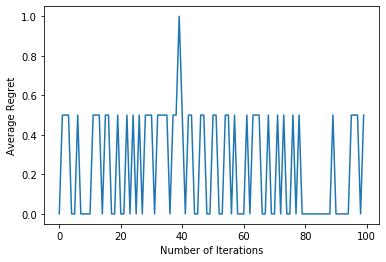

In [12]:
plt.plot(regret_values)
plt.ylabel('Average Regret')
plt.xlabel('Number of Iterations')

And we can observe that the agent tends to improve by reducing average regret over the number of iterations.